In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Import Some Tensorflow and Keras related packages & some model APIs

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.applications.xception import preprocess_input


Using TensorFlow backend.


# Input Pipeline

In the following section, an input pipleline is generated. Separate generators are instantiated from the ImageDataGenerator class in Keras, and data flows from the directory itself. 

In [3]:
# Preparing validation labels from val_annotations.txt
val_data = pd.read_csv('/kaggle/input/image-detect/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(5)

,File,Class
0,val_0.JPEG,n07753592
1,val_1.JPEG,n02883205
2,val_2.JPEG,n04532670
3,val_3.JPEG,n03160309
4,val_4.JPEG,n07583066


In [4]:
# Initializing the 3 separated data generators for train/validation/test
# Data augmentation applied only on train data

train_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=1.0,
    height_shift_range=1.0,
    brightness_range=None,
    shear_range=1,
    zoom_range=[0.9,1.1],
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [34]:
# Model / data parameters
num_classes = 200
n_x = 150 # input width
n_y = 150 # input height
n_c = 3 # number of channels ('rgb')

In [6]:
# Creating the generators

# train generator 
train_generator = train_datagen.flow_from_directory( '/kaggle/input/image-detect/train/', 
                                                    target_size=(n_x, n_y), 
                                                    color_mode='rgb', 
                                                    batch_size=256, 
                                                    class_mode='categorical', 
                                                    shuffle=True, 
                                                    seed=42)

#validation generator : labels from val_data, created earlier
validation_generator = valid_datagen.flow_from_dataframe(val_data, 
                                                         directory='/kaggle/input/image-detect/val/images/', 
                                                         x_col='File', y_col='Class', 
                                                         target_size=(n_x, n_y),
                                                         color_mode='rgb', 
                                                         class_mode='categorical', 
                                                         batch_size=256, 
                                                         shuffle=True, 
                                                         seed=42)

#test generator initialized later


Found 90000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
Found 10000 images belonging to 1 classes.


In [7]:
# Creates a dictionary mapping classes to corresponding word descriptions (wnids.txt to words.txt)
words = pd.read_csv('/kaggle/input/image-detect/words.txt', sep='\t', header=None, names=['Class', 'Words'])
word_id = pd.read_csv('/kaggle/input/image-detect/wnids.txt', sep='\t', header=None, names=['Class'])['Class'].values
id2words = {}
for ids in word_id:
    id2words[ids] = words.loc[words['Class']==ids,'Words'].to_string(index=False).split(",")[0]
    
#print(id2words)


# Visualizing the Generator Images

This section creates a grid to visualize the inputs after applied augemntation 

In [8]:
from PIL import Image
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid
import math
%matplotlib inline

def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(id2words[class_mapping[y_int[i]]])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

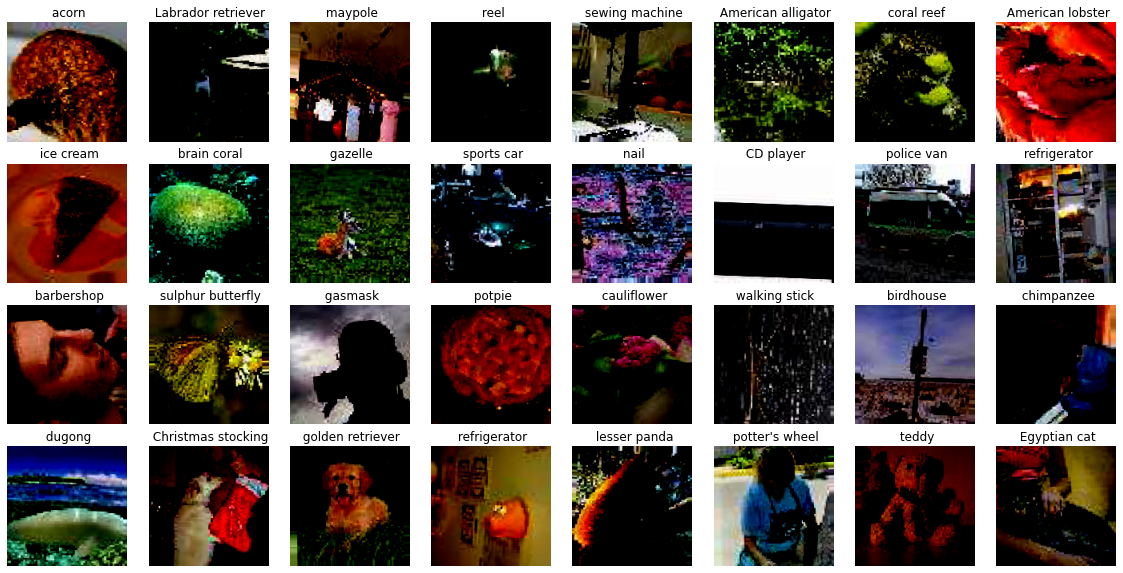

In [9]:
class_mapping = {v:k for k,v in train_generator.class_indices.items()}

x,y = next(train_generator)
#Get class int val from one hot encoded labels
y_int = np.argmax(y,axis=-1)

# Visualising the training dataset
show_grid(x,4,8,label_list=y,show_labels=True,figsize=(20,10))


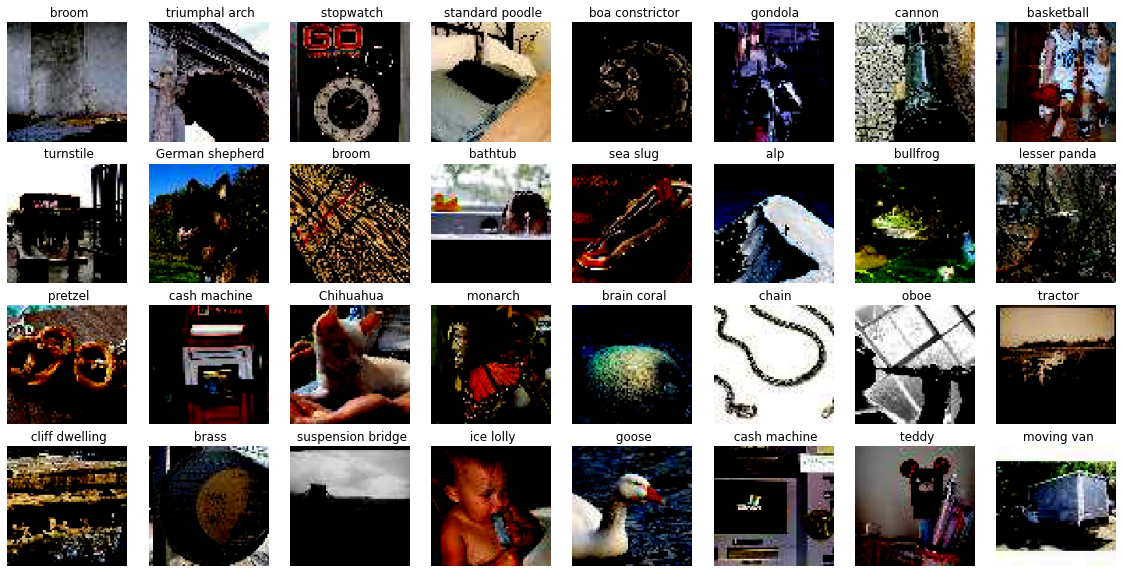

In [10]:
class_mapping = {v:k for k,v in validation_generator.class_indices.items()}

x,y = next(validation_generator)
#Get class int val from one hot encoded labels
y_int = np.argmax(y,axis=-1)

# Visualising the validation dataset
show_grid(x,4,8,label_list=y,show_labels=True,figsize=(20,10))

# Getting comfortable with the Input Pipeline

Exploring how the generator works, and the input format we are dealing with

In [11]:
# Understanding generators and how they work

print(train_generator.filenames[:5])
x,y = next (train_generator) # generates next batch (size: 256)
print('x: ',type(x)) # 256 rgb images
print('y: ',type(y)) # 256 (corresponding) one-hot encoded labels from 200 classes
print('x: ',x.shape)
print('y: ',y.shape)

print(validation_generator.filenames[:5])
x1,y1 = next(validation_generator) # generates next batch (size: 256)
print('x1: ',type(x1)) # 256 rgb images
print('y1: ',type(y1)) # 256 (corresponding) one-hot encoded labels from 200 classes
print('x1: ',x1.shape)
print('y1: ',y1.shape)


['n01443537/images/n01443537_0.JPEG', 'n01443537/images/n01443537_1.JPEG', 'n01443537/images/n01443537_10.JPEG', 'n01443537/images/n01443537_100.JPEG', 'n01443537/images/n01443537_101.JPEG']
x:  <class 'numpy.ndarray'>
y:  <class 'numpy.ndarray'>
x:  (256, 150, 150, 3)
y:  (256, 200)
['val_0.JPEG', 'val_1.JPEG', 'val_2.JPEG', 'val_3.JPEG', 'val_4.JPEG']
x1:  <class 'numpy.ndarray'>
y1:  <class 'numpy.ndarray'>
x1:  (256, 150, 150, 3)
y1:  (256, 200)


# Model
This version uses an Xception Net as the base model. The final layer is removed and replaced with 2 Dense (FC) layers, with a dropout layer (65% and 25%) before each of them respectively. The base layers are frozen and the 2 FC layers are trained for 8 epochs till convergence. Then, the base layers are unfrozen and the entire model is trained with a very low learning rate (1e-05) for 20 epochs 

In [12]:
# Make the MODEL here

# Import the Base Model (Xception Net) with Pre trained weight 
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(n_x, n_y, n_c),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

inputs = keras.Input(shape=(n_x, n_y, n_c))

# FREEZE base model weights
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.65)(x) # Regularisation
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.25)(x) # Regularisation
# A Dense classifier for 200 classes
outputs = keras.layers.Dense(200, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary()


83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
______________________________________________________________

In [15]:
batch_size = 256
epochs = 5
step_size_train=train_generator.n//train_generator.batch_size
step_size_valid=validation_generator.n//validation_generator.batch_size

checkpoint_filepath = '../input/output/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=1,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


In [16]:
# TRAIN the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit_generator(train_generator, epochs=epochs, steps_per_epoch=step_size_train, validation_steps=step_size_valid, validation_data=validation_generator, verbose=1)

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

Epoch 1/5
351/351 [==============================] - 722s 2s/step - loss: 2.6883 - accuracy: 0.4166 - val_loss: 1.8533 - val_accuracy: 0.5637
Epoch 2/5
351/351 [==============================] - 576s 2s/step - loss: 2.1298 - accuracy: 0.5051 - val_loss: 1.7930 - val_accuracy: 0.5721
Epoch 3/5
351/351 [==============================] - 570s 2s/step - loss: 2.0403 - accuracy: 0.5195 - val_loss: 1.7710 - val_accuracy: 0.5764
Epoch 4/5
351/351 [==============================] - 567s 2s/step - loss: 1.9863 - accuracy: 0.5295 - val_loss: 1.7697 - val_accuracy: 0.5810
Epoch 5/5
351/351 [==============================] - 566s 2s/step - loss: 1.9581 - accuracy: 0.5312 - val_loss: 1.7866 - val_accuracy: 0.5812
FINAL ACCURACY MEAN-5:  0.5748998403549195


In [17]:
model.save('model_6_epoch5.h5')

In [18]:
# TRAIN the model

history = model.fit_generator(train_generator, epochs=3, steps_per_epoch=step_size_train, validation_steps=step_size_valid, validation_data=validation_generator, verbose=1)

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

Epoch 1/3
351/351 [==============================] - 568s 2s/step - loss: 1.9338 - accuracy: 0.5361 - val_loss: 1.7866 - val_accuracy: 0.5798
Epoch 2/3
351/351 [==============================] - 567s 2s/step - loss: 1.9121 - accuracy: 0.5380 - val_loss: 1.7763 - val_accuracy: 0.5839
Epoch 3/3
351/351 [==============================] - 570s 2s/step - loss: 1.9002 - accuracy: 0.5403 - val_loss: 1.7920 - val_accuracy: 0.5814
FINAL ACCURACY MEAN-5:  0.5817307829856873


In [ ]:
model.save('model_6_epoch8.h5')

# Fine-Tuning End to End

Base Model is noe set to trainable, Learning rate is significantly reduced

In [19]:
# unfrezing the base layers of the Xception net and training the whole model
base_model.trainable = True
model.summary()
optimizer = keras.optimizers.Adam(lr=1e-5) # Low learning rate
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               205000

In [20]:
history = model.fit_generator(train_generator, epochs=5, steps_per_epoch=step_size_train, validation_steps=step_size_valid, validation_data=validation_generator, verbose=1)

final_accuracy = history.history["val_accuracy"][-2:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

Epoch 1/5
351/351 [==============================] - 747s 2s/step - loss: 1.5011 - accuracy: 0.6255 - val_loss: 1.3140 - val_accuracy: 0.6824
Epoch 2/5
351/351 [==============================] - 731s 2s/step - loss: 1.3376 - accuracy: 0.6641 - val_loss: 1.2353 - val_accuracy: 0.7006
Epoch 3/5
351/351 [==============================] - 731s 2s/step - loss: 1.2540 - accuracy: 0.6828 - val_loss: 1.1883 - val_accuracy: 0.7062
Epoch 4/5
351/351 [==============================] - 732s 2s/step - loss: 1.1943 - accuracy: 0.6954 - val_loss: 1.1403 - val_accuracy: 0.7162
Epoch 5/5
351/351 [==============================] - 732s 2s/step - loss: 1.1491 - accuracy: 0.7076 - val_loss: 1.1138 - val_accuracy: 0.7232
FINAL ACCURACY MEAN-5:  0.7197015285491943


In [21]:
model.save('model_6_epoch8_ft5.h5')

In [22]:
history = model.fit_generator(train_generator, epochs=5, steps_per_epoch=step_size_train, validation_steps=step_size_valid, validation_data=validation_generator, verbose=1)

final_accuracy = history.history["val_accuracy"][-2:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

Epoch 1/5
351/351 [==============================] - 734s 2s/step - loss: 1.1002 - accuracy: 0.7174 - val_loss: 1.0941 - val_accuracy: 0.7268
Epoch 2/5
351/351 [==============================] - 739s 2s/step - loss: 1.0699 - accuracy: 0.7240 - val_loss: 1.0759 - val_accuracy: 0.7318
Epoch 3/5
351/351 [==============================] - 732s 2s/step - loss: 1.0256 - accuracy: 0.7369 - val_loss: 1.0584 - val_accuracy: 0.7364
Epoch 4/5
351/351 [==============================] - 735s 2s/step - loss: 0.9929 - accuracy: 0.7420 - val_loss: 1.0379 - val_accuracy: 0.7411
Epoch 5/5
351/351 [==============================] - 733s 2s/step - loss: 0.9669 - accuracy: 0.7494 - val_loss: 1.0241 - val_accuracy: 0.7399
FINAL ACCURACY MEAN-5:  0.7404847741127014


In [23]:
model.save('model_6_epoch8_ft10.h5')

In [24]:
history = model.fit_generator(train_generator, epochs=5, steps_per_epoch=step_size_train, validation_steps=step_size_valid, validation_data=validation_generator, verbose=1)

final_accuracy = history.history["val_accuracy"][-2:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

Epoch 1/5
351/351 [==============================] - 736s 2s/step - loss: 0.9377 - accuracy: 0.7538 - val_loss: 1.0189 - val_accuracy: 0.7439
Epoch 2/5
351/351 [==============================] - 733s 2s/step - loss: 0.9131 - accuracy: 0.7598 - val_loss: 1.0051 - val_accuracy: 0.7477
Epoch 3/5
351/351 [==============================] - 739s 2s/step - loss: 0.8855 - accuracy: 0.7675 - val_loss: 0.9996 - val_accuracy: 0.7460
Epoch 4/5
351/351 [==============================] - 765s 2s/step - loss: 0.8589 - accuracy: 0.7724 - val_loss: 0.9897 - val_accuracy: 0.7491
Epoch 5/5
351/351 [==============================] - 741s 2s/step - loss: 0.8393 - accuracy: 0.7764 - val_loss: 0.9820 - val_accuracy: 0.7514
FINAL ACCURACY MEAN-5:  0.7502503991127014


In [25]:
model.save('model_6_epoch8_ft15.h5')

In [26]:
history = model.fit_generator(train_generator, epochs=5, steps_per_epoch=step_size_train, validation_steps=step_size_valid, validation_data=validation_generator, verbose=1)

final_accuracy = history.history["val_accuracy"][-2:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

Epoch 1/5
351/351 [==============================] - 743s 2s/step - loss: 0.8127 - accuracy: 0.7833 - val_loss: 0.9770 - val_accuracy: 0.7527
Epoch 2/5
351/351 [==============================] - 741s 2s/step - loss: 0.7894 - accuracy: 0.7880 - val_loss: 0.9751 - val_accuracy: 0.7523
Epoch 3/5
351/351 [==============================] - 735s 2s/step - loss: 0.7786 - accuracy: 0.7912 - val_loss: 0.9637 - val_accuracy: 0.7568
Epoch 4/5
351/351 [==============================] - 744s 2s/step - loss: 0.7540 - accuracy: 0.7985 - val_loss: 0.9597 - val_accuracy: 0.7577
Epoch 5/5
351/351 [==============================] - 731s 2s/step - loss: 0.7370 - accuracy: 0.8031 - val_loss: 0.9597 - val_accuracy: 0.7568
FINAL ACCURACY MEAN-5:  0.7572616338729858


In [27]:
model.save('model_6_epoch8_ft20.h5')

In [35]:

#test generator : NOT shuffled, to preserve order in output file for submission
test_generator = test_datagen.flow_from_directory(
    directory='/kaggle/input/image-detect/test',
    target_size=(n_x, n_y),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 10000 images belonging to 1 classes.


In [29]:
# Predict on TEST set
step_size_test=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator,
                             steps=step_size_test,
                             verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

10000/10000 [==============================] - 76s 8ms/step


In [36]:
# WRITE test output to csv file for submission
filenames=test_generator.filenames

for i in range(0,len(filenames)):
    filenames[i] = filenames[i][7:]

results=pd.DataFrame({"file_name":filenames,
                      "category":predictions})
results.to_csv("submission_10.csv",index = False)